## CNN

Источники:

https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data

https://github.com/MicrosoftDocs/ml-basics/blob/master/05b%20-%20Convolutional%20Neural%20Networks%20(PyTorch).ipynb

Оригинальный датасет: https://www.kaggle.com/datasets/likhon148/animal-data

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
import torch

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets, transforms

In [ ]:
from tqdm import tqdm

In [ ]:
import torch.nn.functional as F

Загрузим данные. Нам необходимо, чтобы картинки были одинакового размера, поэтому при загрузке применим к ним преобразование, которое будет превращать исходные картинки в изображения размером 128*128 пикселей.

In [ ]:
transform = transforms.Compose([transforms.Resize(128),
                                 transforms.ToTensor()])

In [ ]:
dataset_animals = datasets.ImageFolder('/content/drive/MyDrive/ML_training_data/animals', transform=transform)

In [ ]:
dataset_animals.class_to_idx

{'Cat': 0, 'Lion': 1, 'Tiger': 2}

In [ ]:
len(dataset_animals)

383

Разделим картинки на тренировочные и тестовые:

In [ ]:
#train_set, val_set = torch.utils.data.random_split(dataset_animals, [300, 83])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_idx, validation_idx = train_test_split(np.arange(len(dataset_animals)),
                                             test_size=83,
                                             random_state=0,
                                             shuffle=True,
                                             stratify=dataset_animals.targets)

train_dataset = torch.utils.data.Subset(dataset_animals, train_idx)
validation_dataset = torch.utils.data.Subset(dataset_animals, validation_idx)

Мы будем работать с даталоадерами - объектами, позволяющими итерироваться по тренировочным и тестовым сабсетам, которые удобно подавать в модель:

In [ ]:
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

Во время прохода по даталоадеру каждую итерацию мы будем получать минибатч фиксированной длины batch_size. Минибатч состоит из некоторого количества картинок и их лейблов. Возьмем для примера один минибатч и посмотрим на него:

In [ ]:
images, labels = next(iter(dataloader_train))

In [ ]:
# лейблы картинок в минибатче
labels

tensor([1, 0, 2, 2, 0, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 0, 0, 0, 1, 2, 0, 1, 2, 0,
        0, 0, 2, 0, 1, 2, 2, 0])

In [ ]:
len(labels)

32

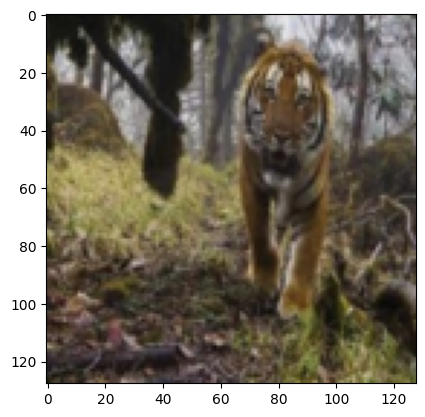

In [ ]:
# одна из картинок минибатча (всего их число равно batch_size)
fig, ax = plt.subplots()
image = images[3].numpy().transpose((1, 2, 0))
ax.imshow(image)

In [ ]:
# в картинке размером 128х128 пикселей три цветовых канала
images[3].shape

torch.Size([3, 128, 128])

### Нейросеть

Мы создадим обычную сверточную нейросеть для классификации изображений с двумя сверточными слоями. Применим один раз дропаут и один раз пулинг.

In [ ]:
class ImageCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.drop = nn.Dropout2d(p=0.2)

        # Для создания выходного слоя нам нужно заранее знать размерность, которую выдает последний скрытый слой.
        # Перед выходным слоем мы сделаем выдачу последней свертки плоской (см. ниже)
        # Поскольку мы один раз применяем pooling=2, измерения наших картинкок уменьшатся с 128 до 64
        # Число же выходных каналов последней свертки равно 24
        # В результате нам нужно получить 3 колонки вероятностей по числу категорий
        self.fc = nn.Linear(in_features=64 * 64 * 24, out_features=3)

    def forward(self, x):

        # первая свертка
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool(x)

        # вторая свертка
        x = self.conv2(x)
        x = self.act2(x)
        x = self.drop(x)

        # превращение последеней свертки в плоский тензор
        x_viewed = x.view(-1, 64 * 64 * 24)

        x = self.fc(x_viewed)

        return x

### По шагам:

Давайте посмотрим, что происходит с данными, поданными в модель, по шагам. Помните, что это только forward pass: обратный проход будет потом, во время тренировки.

Сначала убедимся, что класс модели написан правильно. Сделаем объект модели подобно тому, как делали объекты моделей в sklearn:

In [ ]:
model = ImageCNN().to(device)

Выполним forward pass модели. Так как мы ее еще не обучали, веса в ней инициализированы случайно, поэтому хороших предсказаний не будет.

In [ ]:
probs = model(images.to(device))

Получаем вектор размерностью (размер минибатча*количество классов):

In [ ]:
probs.size()

torch.Size([32, 3])

То, что мы получили, называется **логитами** - финальными предсказаниями модели, еще не прошедшими через последнюю функцию активации. Мы не используем активацию на последнем слое, т.к. хотим применить CrossEntropyLoss, который содержит софтмакс-активацию внутри себя.

In [ ]:
# посмотрим на вероятности каждого класса
probs[:10]

tensor([[ 0.0431,  0.0126,  0.0118],
        [ 0.0448,  0.0106,  0.0021],
        [ 0.0486, -0.0453,  0.0161],
        [ 0.0157, -0.0044, -0.0444],
        [-0.0034, -0.0263, -0.0608],
        [ 0.0272, -0.0329, -0.0542],
        [ 0.0182,  0.0026,  0.0089],
        [ 0.0425,  0.0213, -0.0174],
        [ 0.0028, -0.0393, -0.0314],
        [ 0.0760, -0.0578, -0.0945]], device='cuda:0',
       grad_fn=<SliceBackward0>)

Наша первая свертка принимает входное изображение, состоящее из трех каналов input_channels, и преобразовывает его в 12 каналов (out_channels). Ядро свертки имеет размерность 3 (kernel_size), шаг 1 и паддинг 1.

In [ ]:
conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1).to(device)

Пулинг-слой будет снижать размерность свертки в два раза.

In [ ]:
pool = nn.MaxPool2d(kernel_size=2).to(device)

Следующая свертка принимает результаты предыдущей, поэтому в ней 12 входных каналов. Она переведет их в 24:

In [ ]:
conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1).to(device)

Дропаут регуляризует нашу нейросеть:

In [ ]:
drop = nn.Dropout2d(p=0.2).to(device)

Возьмем наш минибатч картинок и посмотрим, как они изменятся в процессе forward pass'a нейросети:

In [ ]:
x = images.to(device)

In [ ]:
x.size()

torch.Size([32, 3, 128, 128])

In [ ]:
x = conv1(x)

In [ ]:
x.size()

torch.Size([32, 12, 128, 128])

In [ ]:
x = pool(x)

In [ ]:
x.size()

torch.Size([32, 12, 64, 64])

In [ ]:
x = conv2(x)

In [ ]:
x.size()

torch.Size([32, 24, 64, 64])

Итак, у нас есть четырехмерный выход сверточных слоев. Но для того, чтобы получить вероятности классов, нам нужна двумерная матрица. Поэтому мы сначала при помощи метода .view() уменьшим размерность, а затем при помощи полносвязного слоя достанем логиты:

In [ ]:
x = x.view(-1, 64 * 64 * 24)

In [ ]:
x.size()

torch.Size([32, 98304])

In [ ]:
fc = nn.Linear(in_features=64 * 64 * 24, out_features=3).to(device)

In [ ]:
x = fc(x)

In [ ]:
x.size()

torch.Size([32, 3])

### Обучение

Нередко в нейросетях считают accuracy, а не f1-score, когда оценивают качество на каждой эпохе. В этот раз мы тоже так сделаем.

In [ ]:
from sklearn.metrics import accuracy_score

Определим функцию потерь и метод оптимизации:

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Мы будем тренироваться 25 эпох.

In [ ]:
n_epochs = 25

for epoch in tqdm(range(n_epochs)):

    epoch_loss = []

    for inputs, labels in dataloader_train:

        optimizer.zero_grad()

        y_pred = model(inputs.to(device))
        loss = loss_fn(y_pred.to(device), labels.to(device))

        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

    acc_scores = []

    # будем сразу на каждой эпохе делать предсказания на тестовом сете и смотреть на качество
    for inputs, labels in dataloader_val:
        y_pred_probs = model(inputs.to(device))
        current_y_pred = torch.argmax(y_pred_probs, 1)
        acc_scores.append(accuracy_score(labels.cpu(), current_y_pred.cpu()))

    avg_acc = np.mean(acc_scores)

    print('Epoch {0}, loss {1}, accuracy {2}'.format(epoch, sum(epoch_loss)/len(epoch_loss), avg_acc))
    epoch_loss = []

  4%|▍         | 1/25 [02:21<56:25, 141.05s/it]

Epoch 0, loss 1.4159353613853454, accuracy 0.3344298245614035


  8%|▊         | 2/25 [02:22<22:36, 59.00s/it] 

Epoch 1, loss 1.1541942954063416, accuracy 0.36951754385964913


 12%|█▏        | 3/25 [02:24<12:00, 32.77s/it]

Epoch 2, loss 1.0343145430088043, accuracy 0.4144736842105263


 16%|█▌        | 4/25 [02:25<07:09, 20.44s/it]

Epoch 3, loss 0.9609208822250366, accuracy 0.5542763157894737


 20%|██        | 5/25 [02:27<04:32, 13.64s/it]

Epoch 4, loss 0.9222402215003968, accuracy 0.606359649122807


 24%|██▍       | 6/25 [02:28<03:01,  9.53s/it]

Epoch 5, loss 0.8149781048297882, accuracy 0.5641447368421052


 28%|██▊       | 7/25 [02:30<02:04,  6.93s/it]

Epoch 6, loss 0.7472634375095367, accuracy 0.5926535087719298


 32%|███▏      | 8/25 [02:32<01:29,  5.28s/it]

Epoch 7, loss 0.7172129154205322, accuracy 0.7006578947368421


 36%|███▌      | 9/25 [02:34<01:07,  4.23s/it]

Epoch 8, loss 0.6477472513914109, accuracy 0.5394736842105263


 40%|████      | 10/25 [02:35<00:51,  3.43s/it]

Epoch 9, loss 0.6473547339439392, accuracy 0.6239035087719298


 44%|████▍     | 11/25 [02:37<00:40,  2.87s/it]

Epoch 10, loss 0.5774138480424881, accuracy 0.6792763157894738


 48%|████▊     | 12/25 [02:38<00:32,  2.48s/it]

Epoch 11, loss 0.5390699028968811, accuracy 0.6831140350877193


 52%|█████▏    | 13/25 [02:40<00:26,  2.23s/it]

Epoch 12, loss 0.4897574245929718, accuracy 0.6973684210526315


 56%|█████▌    | 14/25 [02:42<00:22,  2.05s/it]

Epoch 13, loss 0.4654848277568817, accuracy 0.6787280701754387


 60%|██████    | 15/25 [02:43<00:19,  1.92s/it]

Epoch 14, loss 0.4518214792013168, accuracy 0.7697368421052632


 64%|██████▍   | 16/25 [02:45<00:16,  1.89s/it]

Epoch 15, loss 0.3816771969199181, accuracy 0.7143640350877193


 68%|██████▊   | 17/25 [02:47<00:15,  1.90s/it]

Epoch 16, loss 0.419207489490509, accuracy 0.7143640350877193


 72%|███████▏  | 18/25 [02:49<00:12,  1.83s/it]

Epoch 17, loss 0.37279874831438065, accuracy 0.7105263157894738


 76%|███████▌  | 19/25 [02:50<00:10,  1.76s/it]

Epoch 18, loss 0.35659718215465547, accuracy 0.7494517543859649


 80%|████████  | 20/25 [02:52<00:08,  1.72s/it]

Epoch 19, loss 0.3288601517677307, accuracy 0.756030701754386


 84%|████████▍ | 21/25 [02:54<00:06,  1.68s/it]

Epoch 20, loss 0.28291558623313906, accuracy 0.7176535087719298


 88%|████████▊ | 22/25 [02:55<00:04,  1.66s/it]

Epoch 21, loss 0.3052037373185158, accuracy 0.818530701754386


 92%|█████████▏| 23/25 [02:57<00:03,  1.64s/it]

Epoch 22, loss 0.28536170721054077, accuracy 0.7735745614035089


 96%|█████████▌| 24/25 [02:59<00:01,  1.73s/it]

Epoch 23, loss 0.22815245017409325, accuracy 0.731359649122807


100%|██████████| 25/25 [03:00<00:00,  7.24s/it]

Epoch 24, loss 0.24179949909448623, accuracy 0.7631578947368421


## RNN

Продолжаем изучать классификацию имен по [этому](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) туториалу.

Предобработку берем с прошлого раза.

In [ ]:
import os
from collections import defaultdict

In [ ]:
from tqdm import tqdm

In [ ]:
import random

In [ ]:
import torch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
category_lines = defaultdict(list)

for filename in os.listdir('/content/drive/MyDrive/ML_training_data/names'):
  category_name = filename[:-4]
  with open(os.path.join('/content/drive/MyDrive/ML_training_data/names', filename), 'r') as f:
    lines = f.read().strip().split('\n')
    category_lines[category_name] = lines

In [ ]:
category_lines.keys()

dict_keys(['Chinese', 'Arabic', 'Czech', 'German', 'Korean', 'Japanese', 'Dutch', 'Polish', 'French', 'Greek', 'Portuguese', 'Scottish', 'Irish', 'Spanish', 'English', 'Italian', 'Vietnamese', 'Russian'])

In [ ]:
unique_letters = set()

for k, v in category_lines.items():
  for word in v:
    unique_letters.update(set(word))

In [ ]:
all_letters_list = list(unique_letters)
all_letters = ''.join(all_letters_list)
n_letters = len(all_letters)

In [ ]:
n_letters += 1

In [ ]:
all_categories = list(category_lines.keys())
n_categories = len(all_categories)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


В этот раз закодируем имена по-другому: каждому имени поставим в соответствие вектор размерности (количество букв\*1\*количество уникальных символов). Единица посередине нужна, чтобы притвориться, что каждый вектор является минибатчем размерностью 1 (технический момент для пайторча). Каждый раз, когда мы создаем какой-нибудь тензор, мы сначала создаем тензор из нулей при помощи функции torch.zeros(), а потом заполняем его числами.

In [ ]:
def letterToIndex(letter):
    # преобразование буквы в индекс
    return all_letters.find(letter)


def letterToTensor(letter):
    # преобразование буквы в тензор
    tensor = torch.zeros(1, n_letters)
    if letter in all_letters:
      tensor[0][letterToIndex(letter)] = 1
    else:
      tensor[0][-1] = 1
    return tensor


def lineToTensor(line):
    # преобразование имени в тензор
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor.to(device)


print('7:\n', letterToTensor('7'))
print('Zahar\n', lineToTensor('Zahar'))
print('Zahar - tensor size\n', lineToTensor('Zahar').size())

7:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
Zahar
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0

### Нейросеть

Мы инициализируем рекуррентную нейросеть как обычную с одним входным слоем, двумя скрытыми и одним выходным. Мы будем делать forward pass по входному и скрытому слою, затем суммировать их веса и применять к ним функцию активации, получая скрытые состояния. Их мы затем передадим в выходной слой и примерим софтмакс, т.к. у нас по-прежнему многоклассовая классификация.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.init_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.init_to_hidden(input) + self.hidden_to_hidden(hidden))
        output = self.hidden_to_output(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # поскольку нам нужно чем-то заполнить скрытый слой при самом первом проходе, мы инициализируем его нулями
        return torch.zeros(1, self.hidden_size)

### По шагам

Сначала инициализируем объект модели и посмотрим, что она работает.

In [ ]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).to(device)

Наша рекуррентная нейросеть будет идти по каждой букве слова, сохраняя информацию о предыдущих буквах, чтобы затем сделать предсказание категории, когда буквы закончатся. Давайте попробуем пройтись только по одной букве:

In [ ]:
input = lineToTensor('Zahar')
# перед предсказанием каждого слова нам нужно не только превратить слово в тензор, но и инициализировать скрытый слой:
hidden = rnn.initHidden()

output, next_hidden = rnn(input[0].to(device), hidden.to(device))
print(output)

tensor([[-2.7939, -2.8795, -2.7521, -2.9191, -3.0059, -2.9477, -2.9255, -2.8108,
         -2.9164, -2.8690, -2.8851, -2.9789, -2.8301, -2.9792, -2.8900, -2.9246,
         -2.8822, -2.8747]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


Теперь мы получили уже не логиты, а полноценные предсказания, так как внутри модели есть финальная функция активации - LogSoftmax. Но мы пока что не обучались, так что предсказания не очень хороши.

Если ориентироваться на эту картинку из презентации (Bao et al., 10.1371/journal.pone.0180944), выход output соответствует Ot, а скрытое состояние next_hidden - St:

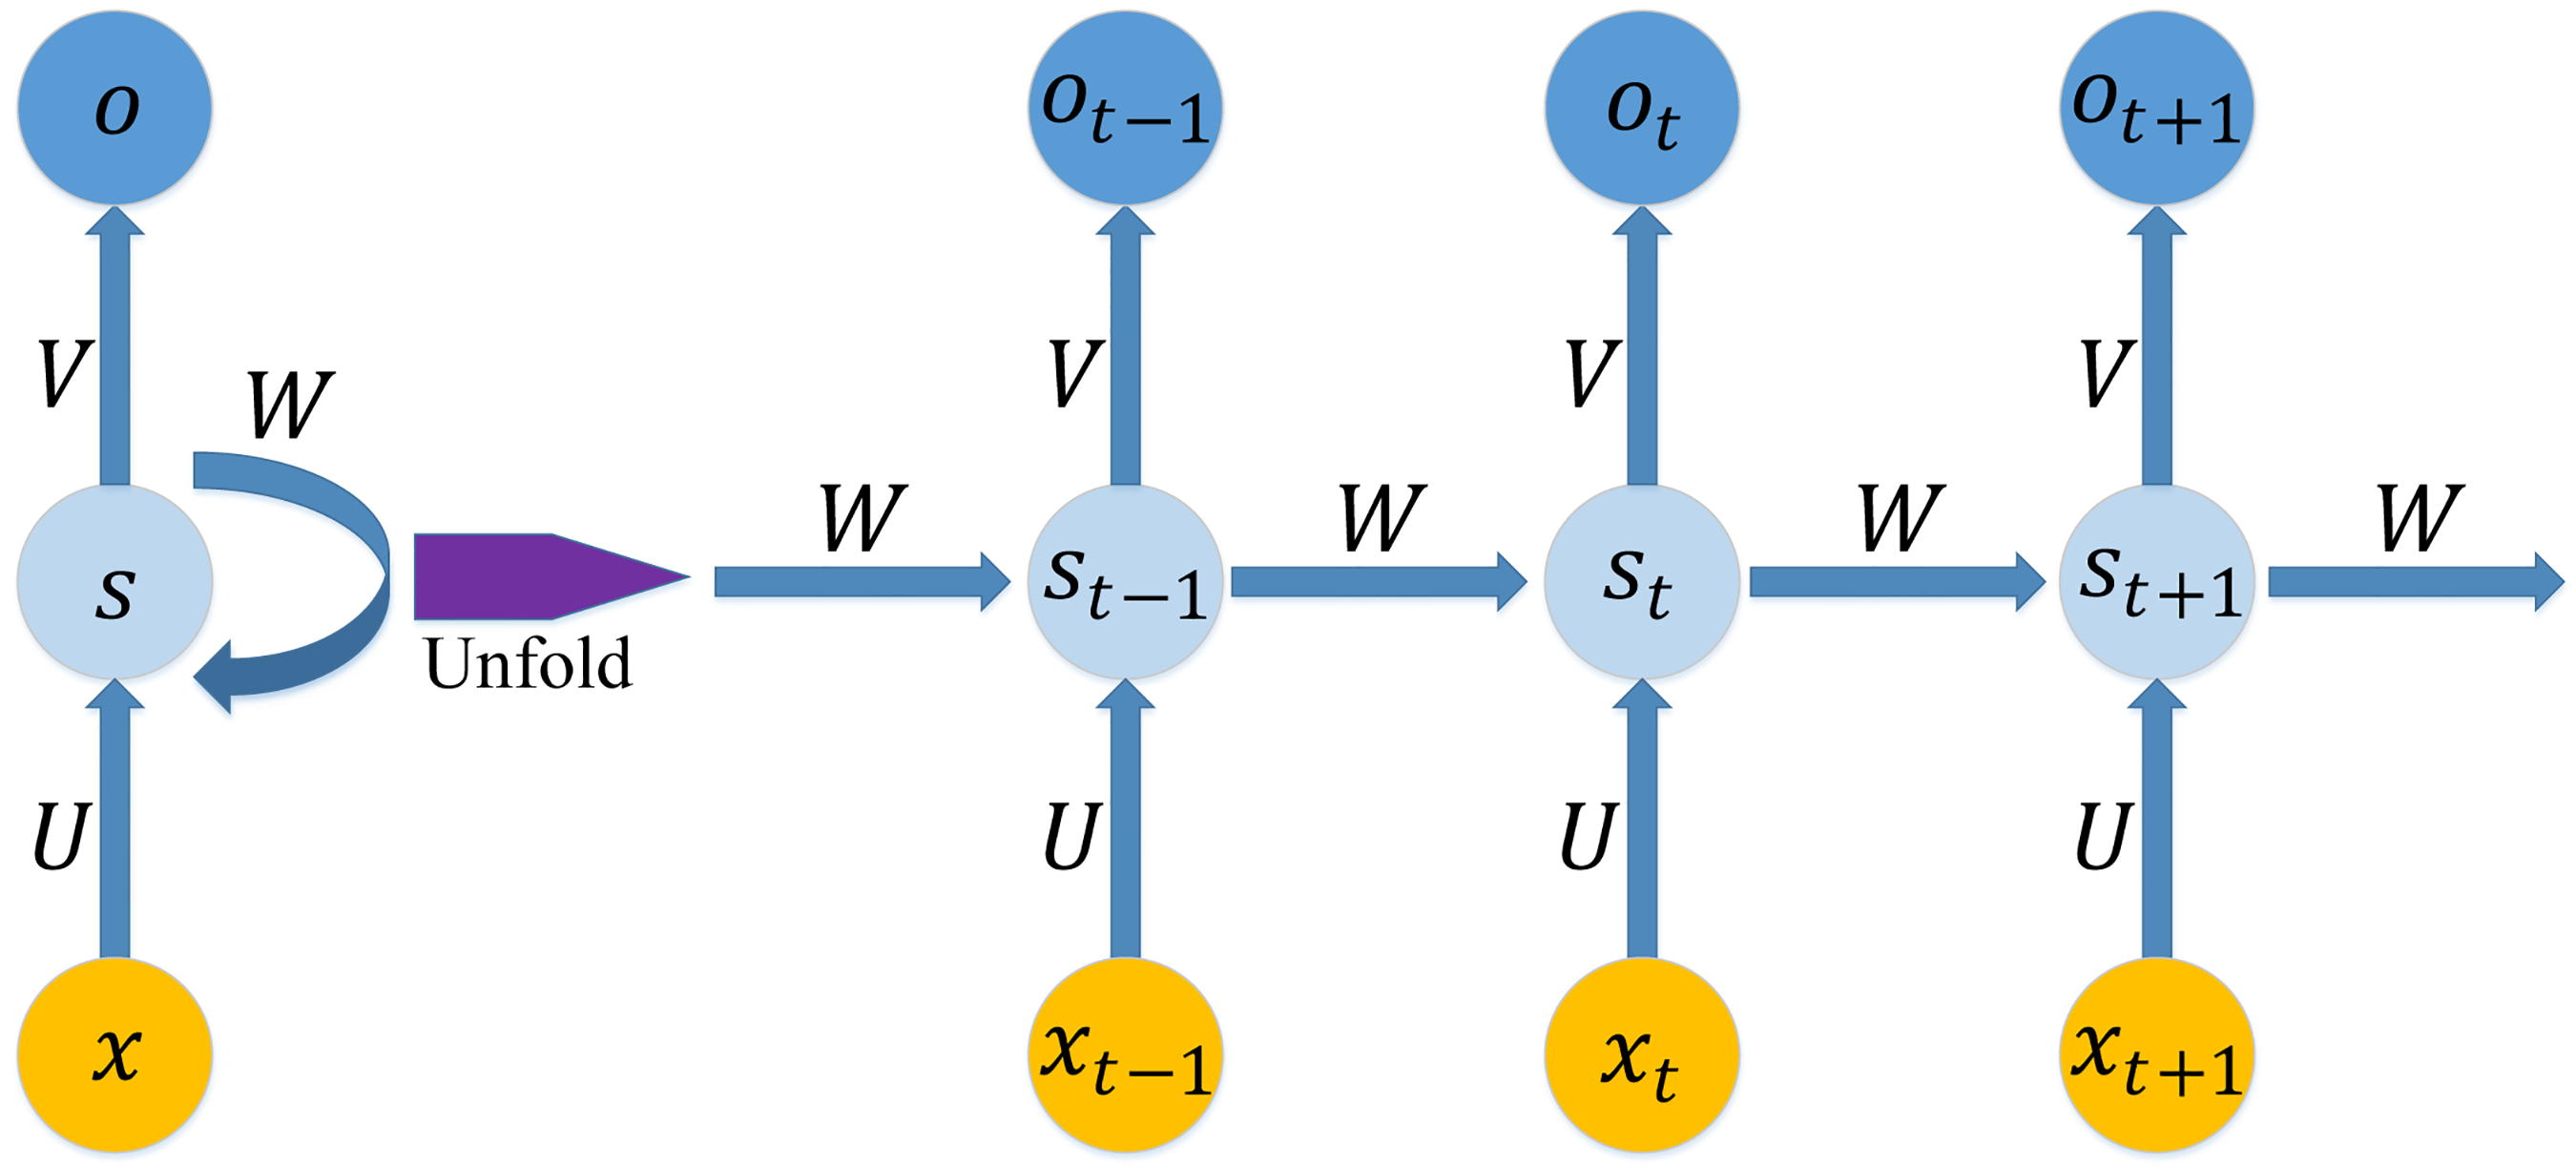

Можно убедиться, что мы получили тот же результат, как если бы подали в нейросеть одну только букву Z:

In [ ]:
input = letterToTensor('Z')
hidden = rnn.initHidden()

output, next_hidden = rnn(input.to(device), hidden.to(device))

In [ ]:
output

tensor([[-2.7939, -2.8795, -2.7521, -2.9191, -3.0059, -2.9477, -2.9255, -2.8108,
         -2.9164, -2.8690, -2.8851, -2.9789, -2.8301, -2.9792, -2.8900, -2.9246,
         -2.8822, -2.8747]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

Давайте разберемся, что происходит внутри нейросети, на примере одной буквы.

In [ ]:
# инициализируем начальное скрытое состояние
hidden_0 = torch.zeros(1, n_hidden)

Во-первых, нам нужно два линейных слоя: один, init_to_hidden, будет принимать закодированную входную букву, второй, hidden_to_hidden, будет принимать скрытое состояние. Во-вторых, нам нужен выходной слой hidden_to_output.

In [ ]:
input_size = n_letters
hidden_size = n_hidden
output_size = n_categories

init_to_hidden = nn.Linear(input_size, hidden_size).to(device)
hidden_to_hidden = nn.Linear(hidden_size, hidden_size).to(device)
hidden_to_output = nn.Linear(hidden_size, output_size).to(device)

In [ ]:
# сам входной вектор буквы выглядит так
input

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Пропустим входную букву и начальное скрытое состояние через соответствующие слои:

In [ ]:
input = init_to_hidden(input.to(device))

In [ ]:
input.size()

torch.Size([1, 128])

In [ ]:
hidden = hidden_to_hidden(hidden_0.to(device))

In [ ]:
hidden.size()

torch.Size([1, 128])

Затем нам нужно просуммировать информацию, полученную от текущей буквы (input) и "контекстную" информацию hidden (хотя никакого контекста мы еще, конечно же, не знаем):

In [ ]:
sum_i_h = input + hidden

In [ ]:
sum_i_h.size()

torch.Size([1, 128])

И применить функцию активации:

In [ ]:
activated = F.tanh(input + hidden)

In [ ]:
activated.size()

torch.Size([1, 128])

Затем можно получать выходы нейросети и превращать их в вероятности при помощи софтмакса:

In [ ]:
output = hidden_to_output(activated)

In [ ]:
output.size()

torch.Size([1, 18])

In [ ]:
softmax = nn.LogSoftmax(dim=1)

In [ ]:
probs = softmax(output)

In [ ]:
probs

tensor([[-2.9554, -2.9556, -2.8475, -2.8333, -2.7538, -3.0080, -2.8707, -2.6767,
         -2.9060, -2.7510, -2.9696, -2.9004, -2.7874, -3.0005, -2.9594, -2.9796,
         -2.9900, -2.9686]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

Мы получили немного другой вектор, чем тот, что выше, поскольку инициализировали все слои заново.

Теперь нам нужно еще написать функцию, которая будет превращать выданные вероятности (probs) в лейбл предсказанной категории:

In [ ]:
def categoryFromOutput(output):
    # перевод выданных вероятностей в категорию
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(probs))

('Polish', 7)


In [ ]:
probs.topk(1)

torch.return_types.topk(
values=tensor([[-2.6767]], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[7]], device='cuda:0'))

Разделение на тестовую и тренировочную выборку:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = []
y = []

for k, v in category_lines.items():
  for w in v:
    X.append(w)
    y.append(k)

In [ ]:
len(X) == len(y)

True

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

### Обучение

Объявим наши гиперпараметры: размерность входного слоя (идентична количеству уникальных букв), размерность скрытого слоя (может быть любой), размерность выходного слоя (равна количеству категорий), количество эпох, learning rate и размер батча (могут быть любыми).

In [ ]:
input_dim = n_letters
hidden_dim = 128
output_dim = len(all_categories)
num_epochs = 100
learning_rate = 3e-4
batch_size = 1000

Передадим все параметры в модель, выберем функцию потерь и оптимайзер и начнем обучение.

In [ ]:
rnn_model = RNN(input_dim, 128, output_dim).to(device)

In [ ]:
loss_function = nn.NLLLoss().to(device)
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

In [ ]:
losses = []

for epoch in tqdm(range(num_epochs)):
    train_loss = 0

    current_batch = random.sample(range(len(X_train)), batch_size)
    current_X_train = [X_train[i] for i in current_batch]
    current_y_train = [y_train[i] for i in current_batch]

    for current_word, current_category in zip(current_X_train, current_y_train):

      hidden = rnn.initHidden()

      # Очищаем градиент, аккумулированный на предыдущих этапах
      optimizer.zero_grad()

      # кодируем имя и категорию, превращая их в тензоры
      line_tensor = lineToTensor(current_word)
      category_tensor = torch.tensor([all_categories.index(current_category)], dtype=torch.long)

      # forward pass: идем по каждой букве, обновляем веса и получаем вероятности классов для слова
      for i in range(line_tensor.size()[0]):
        output, hidden = rnn_model(line_tensor[i].to(device), hidden.to(device))

      # считаем значение функции потерь и добавляем его к общему лоссу этой эпохи
      loss = loss_function(output, category_tensor.to(device))
      train_loss += loss.item()

      # backward pass: распространяем ошибку обратно, чтобы проапдейтить веса
      loss.backward()

      # Апдейтим веса
      optimizer.step()

    losses.append(train_loss/batch_size)

    print('Epoch {0}, loss {1}'.format(epoch, train_loss/batch_size))

    # перед следующей эпохой зануляем лосс
    train_loss = 0

  1%|          | 1/100 [00:03<06:02,  3.66s/it]

Epoch 0, loss 1.7825900527089835


  2%|▏         | 2/100 [00:07<05:58,  3.66s/it]

Epoch 1, loss 1.575803332913667


  3%|▎         | 3/100 [00:11<06:26,  3.98s/it]

Epoch 2, loss 1.3784582288479432


  4%|▍         | 4/100 [00:15<06:08,  3.84s/it]

Epoch 3, loss 1.3760940110622906


  5%|▌         | 5/100 [00:19<05:59,  3.79s/it]

Epoch 4, loss 1.2372138773081824


  6%|▌         | 6/100 [00:23<06:19,  4.04s/it]

Epoch 5, loss 1.2008357272141148


  7%|▋         | 7/100 [00:27<06:07,  3.95s/it]

Epoch 6, loss 1.1672252038569422


  8%|▊         | 8/100 [00:30<05:54,  3.85s/it]

Epoch 7, loss 1.1333860609829425


  9%|▉         | 9/100 [00:34<05:52,  3.87s/it]

Epoch 8, loss 1.1315921007249272


 10%|█         | 10/100 [00:38<05:52,  3.92s/it]

Epoch 9, loss 1.0566319336523884


 11%|█         | 11/100 [00:42<05:41,  3.83s/it]

Epoch 10, loss 1.0559403845200432


 12%|█▏        | 12/100 [00:46<05:30,  3.76s/it]

Epoch 11, loss 1.0270546319523128


 13%|█▎        | 13/100 [00:50<05:42,  3.94s/it]

Epoch 12, loss 1.0239576151785732


 14%|█▍        | 14/100 [00:54<05:31,  3.86s/it]

Epoch 13, loss 1.0692621972374619


 15%|█▌        | 15/100 [00:57<05:21,  3.78s/it]

Epoch 14, loss 0.9604073957989167


 16%|█▌        | 16/100 [01:02<05:30,  3.93s/it]

Epoch 15, loss 1.0185365552224392


 17%|█▋        | 17/100 [01:05<05:21,  3.87s/it]

Epoch 16, loss 1.0336199286535557


 18%|█▊        | 18/100 [01:09<05:10,  3.79s/it]

Epoch 17, loss 0.9537655397368944


 19%|█▉        | 19/100 [01:13<05:08,  3.81s/it]

Epoch 18, loss 0.9196192101456981


 20%|██        | 20/100 [01:17<05:11,  3.90s/it]

Epoch 19, loss 0.9311397512163967


 21%|██        | 21/100 [01:20<05:01,  3.82s/it]

Epoch 20, loss 0.8865744219870249


 22%|██▏       | 22/100 [01:24<04:54,  3.77s/it]

Epoch 21, loss 0.9046527278446301


 23%|██▎       | 23/100 [01:28<05:04,  3.96s/it]

Epoch 22, loss 0.8799389707028895


 24%|██▍       | 24/100 [01:32<04:51,  3.84s/it]

Epoch 23, loss 0.983199457434559


 25%|██▌       | 25/100 [01:36<04:43,  3.78s/it]

Epoch 24, loss 0.8476423352219427


 26%|██▌       | 26/100 [01:40<04:48,  3.90s/it]

Epoch 25, loss 0.8474958121843956


 27%|██▋       | 27/100 [01:44<04:42,  3.88s/it]

Epoch 26, loss 0.8680766579538758


 28%|██▊       | 28/100 [01:47<04:33,  3.80s/it]

Epoch 27, loss 0.8794781578399997


 29%|██▉       | 29/100 [01:51<04:28,  3.78s/it]

Epoch 28, loss 0.8529164374315442


 30%|███       | 30/100 [01:55<04:36,  3.95s/it]

Epoch 29, loss 0.8428751597488153


 31%|███       | 31/100 [01:59<04:24,  3.84s/it]

Epoch 30, loss 0.8401424363276601


 32%|███▏      | 32/100 [02:03<04:16,  3.77s/it]

Epoch 31, loss 0.8377821517094562


 33%|███▎      | 33/100 [02:07<04:24,  3.95s/it]

Epoch 32, loss 0.8365407019852573


 34%|███▍      | 34/100 [02:11<04:14,  3.85s/it]

Epoch 33, loss 0.8253622317639819


 35%|███▌      | 35/100 [02:14<04:05,  3.78s/it]

Epoch 34, loss 0.8336899433470971


 36%|███▌      | 36/100 [02:18<04:05,  3.83s/it]

Epoch 35, loss 0.8666953918188083


 37%|███▋      | 37/100 [02:22<04:02,  3.85s/it]

Epoch 36, loss 0.8380386260848827


 38%|███▊      | 38/100 [02:26<03:56,  3.81s/it]

Epoch 37, loss 0.7767545295302698


 39%|███▉      | 39/100 [02:29<03:48,  3.74s/it]

Epoch 38, loss 0.8238231447250437


 40%|████      | 40/100 [02:34<03:55,  3.92s/it]

Epoch 39, loss 0.7718412604395853


 41%|████      | 41/100 [02:37<03:45,  3.83s/it]

Epoch 40, loss 0.7850571293313696


 42%|████▏     | 42/100 [02:41<03:38,  3.77s/it]

Epoch 41, loss 0.8021276879352371


 43%|████▎     | 43/100 [02:45<03:44,  3.94s/it]

Epoch 42, loss 0.761647169574986


 44%|████▍     | 44/100 [02:49<03:34,  3.83s/it]

Epoch 43, loss 0.8390227959201438


 45%|████▌     | 45/100 [02:52<03:26,  3.76s/it]

Epoch 44, loss 0.7677299912491581


 46%|████▌     | 46/100 [02:56<03:26,  3.82s/it]

Epoch 45, loss 0.7670477256803788


 47%|████▋     | 47/100 [03:00<03:25,  3.88s/it]

Epoch 46, loss 0.8316512210434739


 48%|████▊     | 48/100 [03:04<03:17,  3.80s/it]

Epoch 47, loss 0.8760905094966219


 49%|████▉     | 49/100 [03:08<03:10,  3.73s/it]

Epoch 48, loss 0.8349569811764631


 50%|█████     | 50/100 [03:12<03:16,  3.94s/it]

Epoch 49, loss 0.7307233498360365


 51%|█████     | 51/100 [03:16<03:08,  3.84s/it]

Epoch 50, loss 0.7657754732170869


 52%|█████▏    | 52/100 [03:19<03:00,  3.76s/it]

Epoch 51, loss 0.7688308467025927


 53%|█████▎    | 53/100 [03:23<03:03,  3.90s/it]

Epoch 52, loss 0.820333383649031


 54%|█████▍    | 54/100 [03:27<02:57,  3.87s/it]

Epoch 53, loss 0.7243269058288206


 55%|█████▌    | 55/100 [03:31<02:49,  3.77s/it]

Epoch 54, loss 0.7887449553027763


 56%|█████▌    | 56/100 [03:35<02:47,  3.80s/it]

Epoch 55, loss 0.7209020625149278


 57%|█████▋    | 57/100 [03:39<02:48,  3.92s/it]

Epoch 56, loss 0.700687585264699


 58%|█████▊    | 58/100 [03:42<02:40,  3.83s/it]

Epoch 57, loss 0.7624249190605479


 59%|█████▉    | 59/100 [03:46<02:34,  3.77s/it]

Epoch 58, loss 0.7297161273331658


 60%|██████    | 60/100 [03:50<02:37,  3.95s/it]

Epoch 59, loss 0.7645868290387443


 61%|██████    | 61/100 [03:54<02:31,  3.88s/it]

Epoch 60, loss 0.7036335008985334


 62%|██████▏   | 62/100 [03:58<02:23,  3.78s/it]

Epoch 61, loss 0.7809377830588419


 63%|██████▎   | 63/100 [04:02<02:23,  3.89s/it]

Epoch 62, loss 0.6786337871940196


 64%|██████▍   | 64/100 [04:06<02:19,  3.87s/it]

Epoch 63, loss 0.6417366926872273


 65%|██████▌   | 65/100 [04:09<02:13,  3.82s/it]

Epoch 64, loss 0.6581549486054464


 66%|██████▌   | 66/100 [04:13<02:09,  3.82s/it]

Epoch 65, loss 0.6707669234985005


 67%|██████▋   | 67/100 [04:17<02:08,  3.91s/it]

Epoch 66, loss 0.6718791231433097


 68%|██████▊   | 68/100 [04:21<02:02,  3.82s/it]

Epoch 67, loss 0.7092237987710396


 69%|██████▉   | 69/100 [04:25<01:56,  3.77s/it]

Epoch 68, loss 0.7010091621571264


 70%|███████   | 70/100 [04:29<01:57,  3.92s/it]

Epoch 69, loss 0.7125531507687046


 71%|███████   | 71/100 [04:32<01:51,  3.83s/it]

Epoch 70, loss 0.7340689528557487


 72%|███████▏  | 72/100 [04:36<01:45,  3.78s/it]

Epoch 71, loss 0.6775479310245791


 73%|███████▎  | 73/100 [04:40<01:44,  3.88s/it]

Epoch 72, loss 0.6944363036899558


 74%|███████▍  | 74/100 [04:44<01:40,  3.87s/it]

Epoch 73, loss 0.7210312185878702


 75%|███████▌  | 75/100 [04:48<01:34,  3.79s/it]

Epoch 74, loss 0.6510818606277826


 76%|███████▌  | 76/100 [04:51<01:30,  3.78s/it]

Epoch 75, loss 0.6799088483737178


 77%|███████▋  | 77/100 [04:56<01:30,  3.95s/it]

Epoch 76, loss 0.6914728327302692


 78%|███████▊  | 78/100 [04:59<01:24,  3.83s/it]

Epoch 77, loss 0.6571646917356465


 79%|███████▉  | 79/100 [05:03<01:19,  3.76s/it]

Epoch 78, loss 0.6749458030654205


 80%|████████  | 80/100 [05:07<01:18,  3.95s/it]

Epoch 79, loss 0.6819145090414968


 81%|████████  | 81/100 [05:11<01:12,  3.84s/it]

Epoch 80, loss 0.6666850323468861


 82%|████████▏ | 82/100 [05:15<01:08,  3.78s/it]

Epoch 81, loss 0.7090019028199603


 83%|████████▎ | 83/100 [05:19<01:05,  3.84s/it]

Epoch 82, loss 0.6550515766447861


 84%|████████▍ | 84/100 [05:22<01:01,  3.87s/it]

Epoch 83, loss 0.6633858243859104


 85%|████████▌ | 85/100 [05:26<00:57,  3.82s/it]

Epoch 84, loss 0.7027865770348035


 86%|████████▌ | 86/100 [05:30<00:53,  3.79s/it]

Epoch 85, loss 0.6421845176389215


 87%|████████▋ | 87/100 [05:34<00:52,  4.00s/it]

Epoch 86, loss 0.6223465933015577


 88%|████████▊ | 88/100 [05:38<00:46,  3.92s/it]

Epoch 87, loss 0.6489823647326448


 89%|████████▉ | 89/100 [05:42<00:41,  3.81s/it]

Epoch 88, loss 0.6849741753745948


 90%|█████████ | 90/100 [05:46<00:39,  3.96s/it]

Epoch 89, loss 0.6764926923389103


 91%|█████████ | 91/100 [05:50<00:34,  3.85s/it]

Epoch 90, loss 0.6302685578543987


 92%|█████████▏| 92/100 [05:53<00:30,  3.78s/it]

Epoch 91, loss 0.6497403710539038


 93%|█████████▎| 93/100 [05:57<00:27,  3.89s/it]

Epoch 92, loss 0.5907247465312102


 94%|█████████▍| 94/100 [06:01<00:23,  3.92s/it]

Epoch 93, loss 0.6725424639756957


 95%|█████████▌| 95/100 [06:05<00:19,  3.85s/it]

Epoch 94, loss 0.6528979963173842


 96%|█████████▌| 96/100 [06:09<00:15,  3.77s/it]

Epoch 95, loss 0.63520525012896


 97%|█████████▋| 97/100 [06:13<00:11,  3.94s/it]

Epoch 96, loss 0.584914198723347


 98%|█████████▊| 98/100 [06:17<00:07,  3.84s/it]

Epoch 97, loss 0.6174991609145909


 99%|█████████▉| 99/100 [06:20<00:03,  3.78s/it]

Epoch 98, loss 0.6124142080714564


100%|██████████| 100/100 [06:25<00:00,  3.85s/it]

Epoch 99, loss 0.5776142181642772


Оценим качество тренировки и предсказаний: посмотрим на график лосса и classification_report.

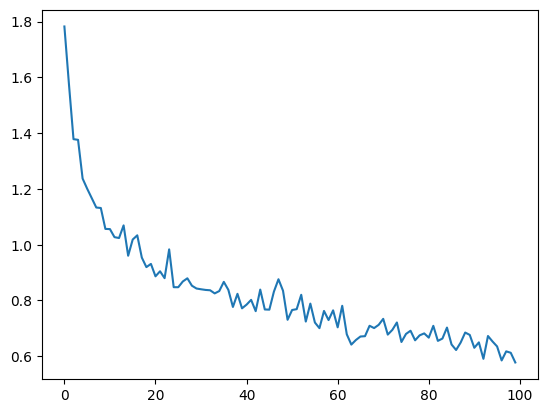

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
from sklearn.metrics import classification_report

rnn_predictions = []
original_lables = []

# этот метод означает, что нам не нужно считать градиент для обратного распространения ошибки, а нужно сделать только предсказания
with torch.no_grad():
  for word, cat in zip(X_test, y_test):
    line_tensor = lineToTensor(word)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_model(line_tensor[i], hidden)

    current_cat, cat_label = categoryFromOutput(output)
    rnn_predictions.append(cat_label)
    original_lables.append(all_categories.index(cat))

In [ ]:
print(classification_report(original_lables, rnn_predictions, target_names=all_categories))

              precision    recall  f1-score   support

     Chinese       0.33      0.03      0.05        67
      Arabic       0.76      0.04      0.08       500
       Czech       0.28      0.12      0.17       130
      German       0.44      0.08      0.14       181
      Korean       0.00      0.00      0.00        24
    Japanese       0.71      0.04      0.08       248
       Dutch       0.00      0.00      0.00        74
      Polish       0.33      0.11      0.17        35
      French       0.09      0.09      0.09        69
       Greek       0.27      0.69      0.38        51
  Portuguese       0.00      0.00      0.00        18
    Scottish       0.00      0.00      0.00        25
       Irish       0.17      0.10      0.13        58
     Spanish       0.10      0.25      0.14        75
     English       0.62      0.37      0.46       917
     Italian       0.30      0.71      0.43       177
  Vietnamese       0.00      0.00      0.00        18
     Russian       0.63    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


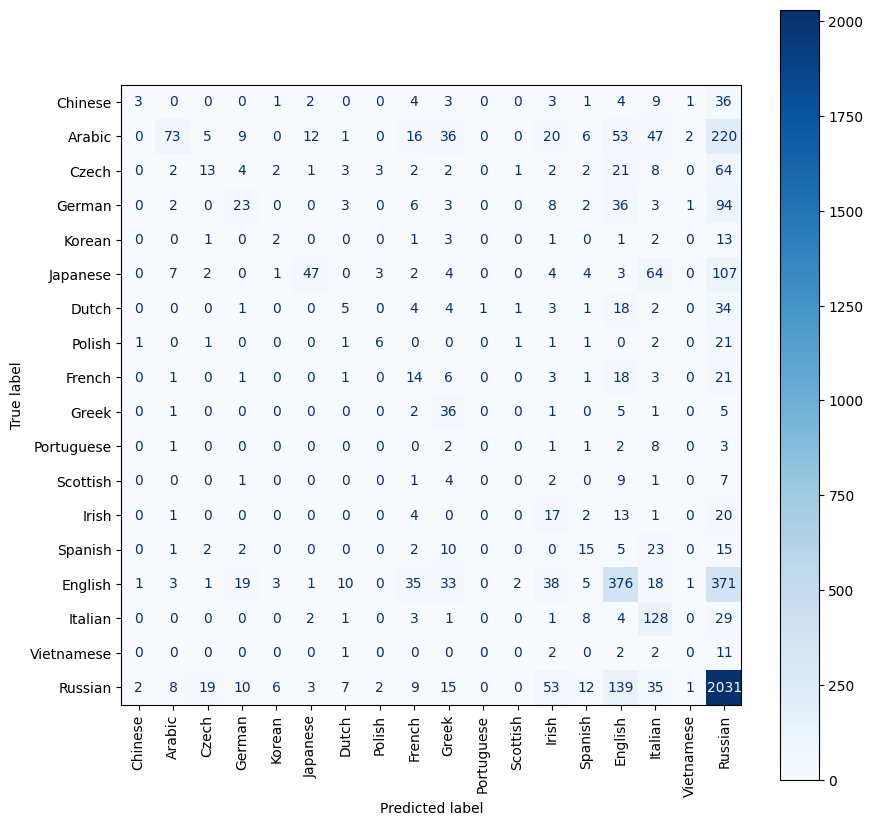

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(original_lables,
                                        rnn_predictions,
                                        display_labels=all_categories,
                                        ax=ax,
                                        xticks_rotation='vertical', cmap='Blues')